# 1.  Data Collection

In [1]:
import twitter # A library to extract text from tweets
import secret_keys # My personal library where the secret Twitter API keys are located

#Instructions on how to setup the API: https://python-twitter.readthedocs.io/en/latest/getting_started.html
api = twitter.Api(consumer_key=secret_keys.consumer_key,
                  consumer_secret=secret_keys.consumer_secret,
                  access_token_key=secret_keys.access_token,
                  access_token_secret=secret_keys.access_token_secret)

# Now search the twitter with a query term
query_term = 'machine learning' # data science, IPL, etc
no_of_tweets = 1000
results = api.GetSearch(term = query_term, count = no_of_tweets, since = '2020-10-01')

# 2. Data Storage

In [2]:
# Creating a list of tweets (Data stored in a format suitable for easy processing)
df = []
for t in results:
    df.append(t.text) 

In [3]:
import pandas as pd

df2 = pd.DataFrame(df)

# Save the dataframe as csv
df2.to_csv('tweets.csv', index = False, header = ['tweet'])

In [4]:
# Load data from csv
df = pd.read_csv('tweets.csv')
df = df['tweet']
df

0     My latest for @hyperallergic was co-written w/...
1     Notice a new feature on @arxiv? Machine learni...
2     Inspired by yesterday's #ArmDevSummit tinyML w...
3     RT @WagnerMenke: Excelente material da astuta ...
4     RT @WagnerMenke: Excelente material da astuta ...
                            ...                        
95    RT @ThinkTankWatch: What does a machine learni...
96    RT @MedicaliPhone: 5 Challenges to Scaling Mac...
97    RT @arduino: Inspired by yesterday's #ArmDevSu...
98    RT @MedicaliPhone: 5 Challenges to Scaling Mac...
99    RT @MedicaliPhone: 5 Challenges to Scaling Mac...
Name: tweet, Length: 100, dtype: object

# 3. Data Cleaning

In [5]:
# Basic NLP data cleaning 
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)


# default NLTK English stopwords
stopwords =set(sw.words('english'))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

def social_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

# 4. Data Representation
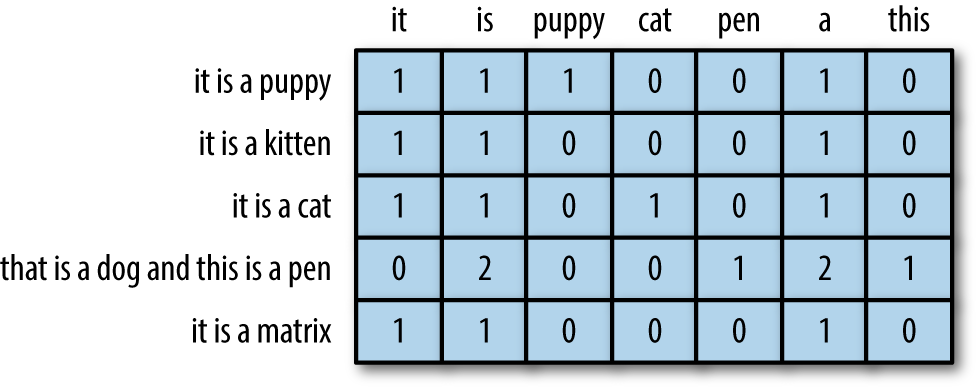
Image source: https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/ch04.html

In [6]:
# tf idf vectoriser
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(tokenizer=social_tokenizer, ngram_range=(1,2))

X = tfidf_vec.fit_transform(df)
feature_names = tfidf_vec.get_feature_names()

# 5. Topic Modelling using NMF

In [7]:
from sklearn.decomposition import NMF
rank = 5
model = NMF(n_components=rank, init='random', random_state=0)
W = model.fit_transform(X) # Document clustering
H = model.components_ # Topic modelling

In [8]:
H

array([[1.27885775e-03, 0.00000000e+00, 0.00000000e+00, ...,
        1.23530400e-04, 2.46628701e-04, 2.46628701e-04],
       [2.92326043e-03, 0.00000000e+00, 0.00000000e+00, ...,
        2.42303968e-02, 2.16750936e-02, 2.16750936e-02],
       [1.72071142e-03, 5.01549363e-01, 5.01549363e-01, ...,
        4.18015690e-03, 3.60193596e-03, 3.60193596e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.05143231e-03, 0.00000000e+00, 0.00000000e+00],
       [3.88944710e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.41632739e-05, 1.00707212e-03, 1.00707212e-03]])

# 6. Visualization

In [9]:
# Visualization of top 10 words in each topic. This is generated based on the values in H
for i,topic in enumerate(H):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vec.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['techopcode practical', 'tensorflow', 'tensorflow java', 'java', 'iot iiot', 'iiot pytorch', 'iiot', 'datascience iot', 'basic bigdata', 'java …']


Top 10 words for topic #1:
['machinelearning learn', 'learn https', 'https', 'https co', 'http', 'http co', 'machine', 'machine learn', 'co', 'learn']


Top 10 words for topic #2:
['marketplace http', 'ajxm9s2fbe', 'rt cloudpreacher', 'base', 'base machine', 'iot 100day', 'machinelearning 100daysofcode', 'blockchain', 'co ajxm9s2fbe', 'blockchain base']


Top 10 words for topic #3:
['co 5no5gtf2zr', 'python amp', 'course', 'free', '5no5gtf2zr', 'complete python', 'complete', 'udemy', 'financial', 'analysis free']


Top 10 words for topic #4:
['english', 'language', 'language important', 'look', 'look global', 'approach', 'approach nlp', 'important nlp', 'global approach', 'nlp']




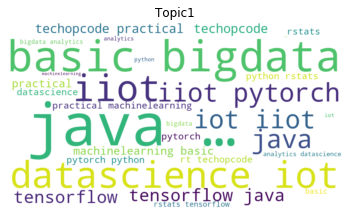

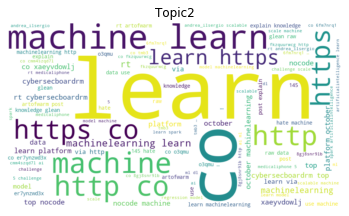

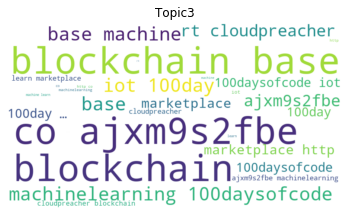

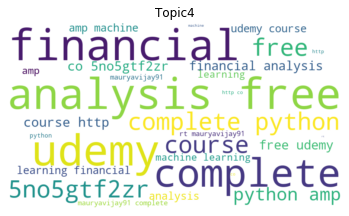

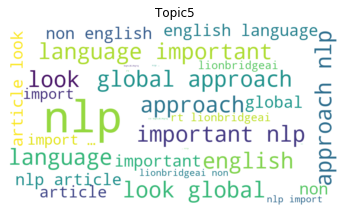

In [10]:
# Visualization of topics as word-cloud
topic_words = []
topic_values = []
n_top_words = 100
for i in range(0,rank):
    topic_words.append([feature_names[i] for i in model.components_[i].argsort()[:-n_top_words - 1 :-1]])
    topic_values.append([model.components_[i][j] for j in model.components_[i].argsort()[:-n_top_words - 1 :-1]])

import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
for i in range(0,5):
    titl = 'Topic'+str(i+1)
    d = {}
    for q in range(0,len(topic_words[i])):
        a = topic_words[i][q]
        #print(a)
        d[topic_words[i][q]] = topic_values[i][q]
    wordcloudi = WordCloud(background_color='white',width=900,height=500, max_words=100,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(frequencies = d)
    plt.imshow(wordcloudi, interpolation='bilinear')
    plt.axis("off")
    plt.title(titl)
    plt.show()
    #plt.imshow(firstcloud)
    #plt.axis('off')
    #plt.show()